# **Employee Attrition** 👷‍♀️👷‍♂️

`Objective:` The key to success in any organization is attracting and retaining top talent. I’m an HR analyst at my company, and one of my tasks is to determine which factors keep employees at my company and which prompt others to leave. I need to know what factors I can change to prevent the loss of good people. Watson Analytics is going to help.



In [11]:
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
from collections import Counter

In [12]:
df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')

In [13]:
df = df[['Attrition', 'Department', 'Gender', 'Age', 'EnvironmentSatisfaction', 'JobSatisfaction', 'MonthlyIncome', 'YearsAtCompany']]
df_clean = df.copy()

In [14]:
df.head()

,Attrition,Department,Gender,Age,EnvironmentSatisfaction,JobSatisfaction,MonthlyIncome,YearsAtCompany
0,Yes,Sales,Female,41,2,4,5993,6
1,No,Research & Development,Male,49,3,2,5130,10
2,Yes,Research & Development,Male,37,4,3,2090,0
3,No,Research & Development,Female,33,4,3,2909,8
4,No,Research & Development,Male,27,1,2,3468,2


In [15]:
df.shape 

(1470, 8)

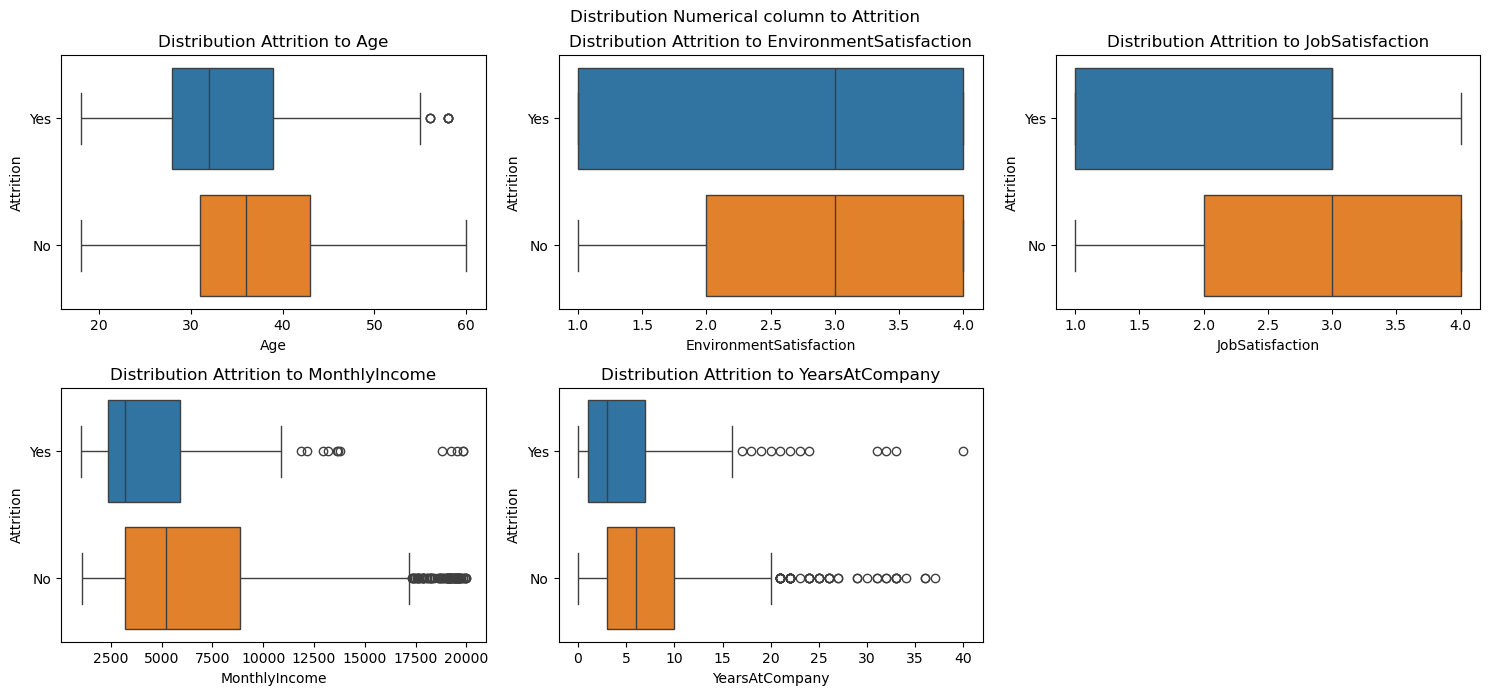

In [16]:
plt.figure(figsize=(15, 10, ))
for i, col in  enumerate(df.select_dtypes(include='number')):
    plt.subplot(3, 3, i+1)
    sns.boxplot(data=df,x=col, y='Attrition', hue='Attrition')
    plt.title(label=f'Distribution Attrition to {col}')
plt.suptitle("Distribution Numerical column to Attrition")
plt.tight_layout()
plt.show()

In [17]:
df.select_dtypes(include='number')

,Age,EnvironmentSatisfaction,JobSatisfaction,MonthlyIncome,YearsAtCompany
0,41,2,4,5993,6
1,49,3,2,5130,10
2,37,4,3,2090,0
3,33,4,3,2909,8
4,27,1,2,3468,2
...,...,...,...,...,...
1465,36,3,4,2571,5
1466,39,4,1,9991,7
1467,27,2,2,6142,6
1468,49,4,2,5390,9


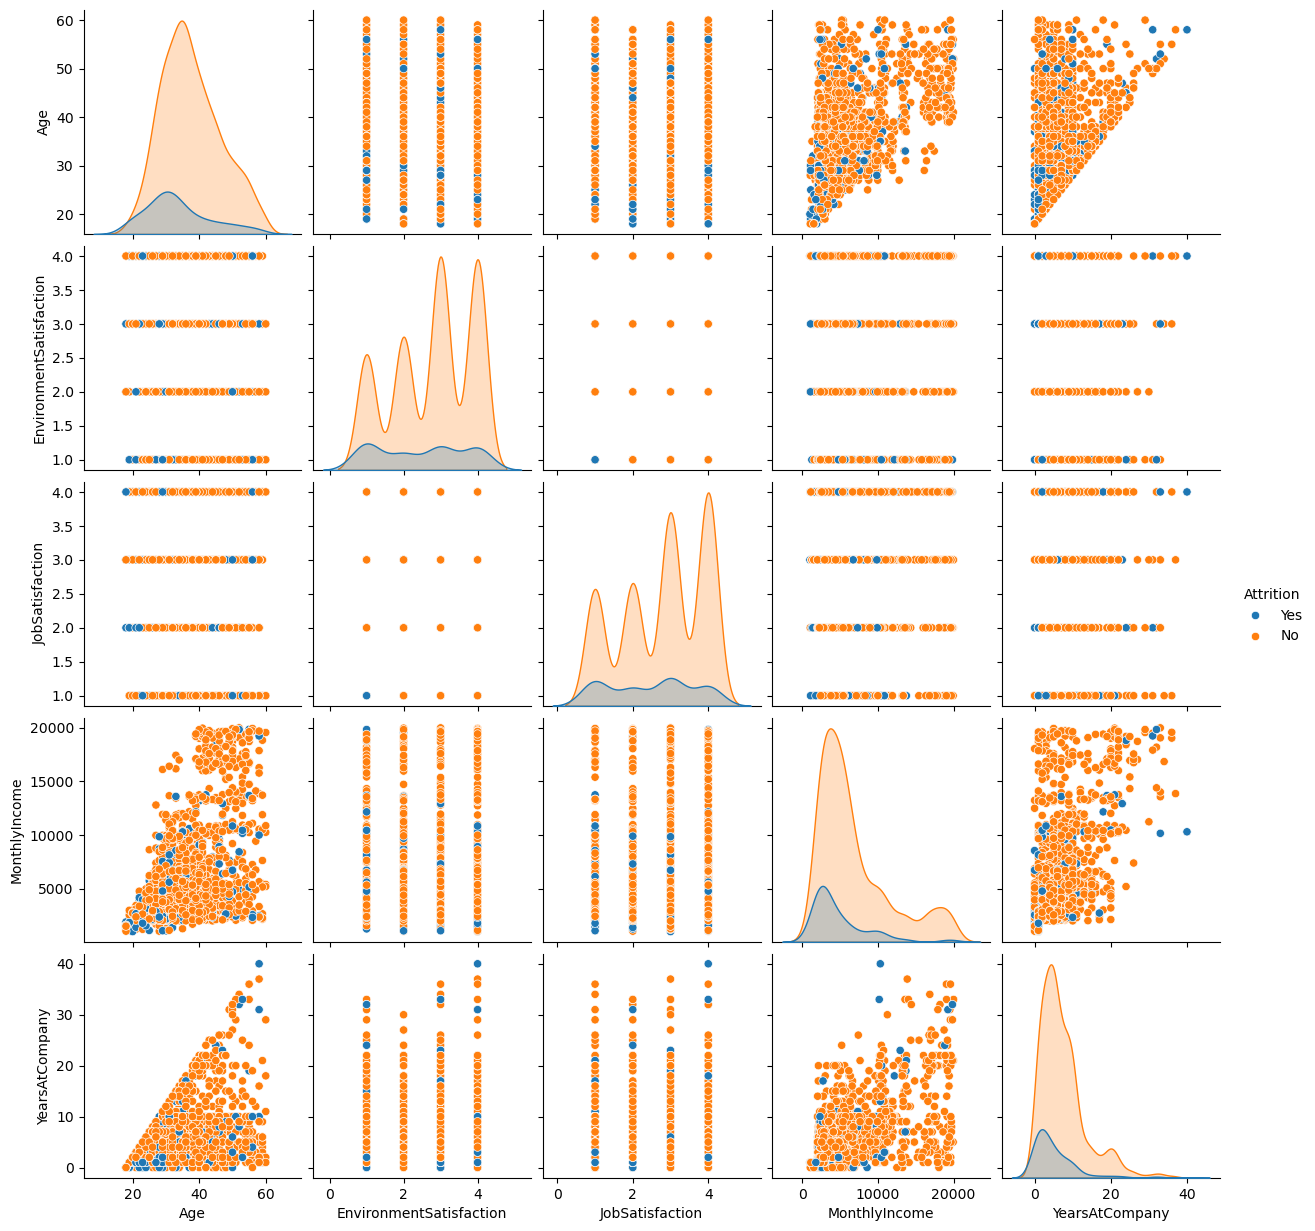

In [18]:
sns.pairplot(df,hue='Attrition')

In [19]:
from collections import deque, Counter
from matplotlib.patches import Patch, ConnectionPatch


In [24]:
class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None, sample=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left 
        self.right = right
        self.info_gain = info_gain
        self.value = value 
        self.sample = sample 



class DecisionTreeClassifier:
    def __init__(self, max_depth=3, min_sample_split=2, min_sample_leaf=1, features=None, mode='gini'):
        self.max_depth = max_depth
        self.min_sample_split = min_sample_split
        self.min_sample_leaf = min_sample_leaf
        self.features = features
        self.mode = mode 

        self.root = None 
        self.feature_importance = None 


    """RECURSIBVE FUNC FOR BUILDING THE TREE"""
    def build_tree(self, dataset, curr_depth=0):
        X, Y = dataset[:, :-1], dataset[:, -1]
        n_samples, n_features = X.shape 

        features = np.arange(n_features)
        if self.features != None:
            features = self.features

        if n_samples>=self.min_sample_split and curr_depth<=self.max_depth:
            best_split = self.get_best_split(dataset, n_samples, features)

            if best_split['info_gain']>0 and len(best_split['dataset_left'])>=self.min_sample_leaf and len(best_split['dataset_right'])>=self.min_sample_leaf:
                feature_index = best_split['feature_index']

                self.feature_importance[0][feature_index] += best_split['info_gain']
                self.feature_importance[1][feature_index] += 1

                left_subtree = self.build_tree(best_split['dataset_left'], curr_depth+1)
                right_subtree = self.build_tree(best_split['dataset_right'], curr_depth+1)
                return Node(
                    feature_index=feature_index, threshold=best_split['threshold'], left=left_subtree, right=right_subtree, info_gain=best_split['info_gain'], sample=Y
                )
        
        leaf_value = self.calc_leaf_value(Y)
        return Node(value=leaf_value, sample=Y)
    
    def get_best_split(self, dataset, n_samples, features):
        best_split = {}
        max_info_gain = -float('inf')

        for feature_index in features:
            possible_thresholds = np.unique(dataset[:, feature_index])
            for threshold in possible_thresholds:
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)

                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]

                    curr_info_gain = self.information_gain(y, left_y, right_y, self.mode)

                    if curr_info_gain > max_info_gain:
                        best_split = {
                            "feature_index": feature_index,
                            "threshold": threshold,
                            "dataset_left": dataset_left,
                            "dataset_right": dataset_right,
                            "info_gain": curr_info_gain,
                        }
                        max_info_gain = curr_info_gain
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        dataset_left = np.array([row for row in dataset if row[feature_index] <= threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index] > threshold])
        return dataset_left, dataset_right
    
    def calc_leaf_value(self, Y):
        Y = list(Y)
        return max(Y, key=Y.count)
    

    """INFORMATION GAIN"""
    def information_gain(self, parent, l_child, r_child, mode):
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode == 'gini':
            gain = self.gini(parent) - (weight_l*self.gini(l_child) + weight_r*self.gini(r_child))
        else:
            gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        return gain
    
    def entropy(self, y):
        classes = np.unique(y)
        entropy = 0
        for cls in classes:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy
    
    def gini(self, y):
        classes = np.unique(y)
        gini = 0
        for cls in classes:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls ** 2
        return 1- gini
    


    """POST PRUNING"""
    def reduced_error_pruning(self, X_test, y_test, tree=None):
        if tree.left and tree.right:
            self.reduced_error_pruning(X_test, y_test, tree.left)
            self.reduced_error_pruning(X_test, y_test, tree.right)

            if tree.left.value != None and tree.right.value != None:
                accuracy_before = np.mean(self.predict(X_test) == y_test)
                tree.value = self.calc_leaf_value(y_test)
                accuracy_pruned = np.mean(self.predict(X_test) == y_test)

                if accuracy_pruned >= accuracy_before:
                    tree.left = None
                    tree.right = None 
                else:
                    tree.value = None 

    def _get_leaves(self, tree=None):
        if tree.value is not None:
            return [tree]
        return self._get_leaves(tree.left) + self._get_leaves(tree.right)    

    def _calc_subtree_cost(self, tree=None):
        if tree is None:
            return 0

        if tree.value is not None:
            y = np.array(tree.sample)
            if self.mode == 'gini':
                return self.gini(y)
            else:
                return self.entropy(y)

        left_cost = self._calc_subtree_cost(tree.left)
        right_cost = self._calc_subtree_cost(tree.right)   
        return left_cost + right_cost + 1

    def cost_complexity_pruning(self, alpha=0.01, tree=None):
        if tree is None:
            tree = self.root 

        if tree.left and tree.right:
            self.cost_complexity_pruning(alpha, tree.left)
            self.cost_complexity_pruning(alpha, tree.right)

            left_cost = self._calc_subtree_cost(tree.left)
            right_cost = self._calc_subtree_cost(tree.right)   

            if (left_cost + right_cost - 1) * alpha >= tree.info_gain:
                tree.value = self.calc_leaf_value([leaf.value for leaf in self._get_leaves(tree)])
                tree.left = tree.right = None 
        return tree



    """FIT AND PREDICT"""
    def fit(self, X, Y):
        dataset = np.concatenate((X, Y), axis=1)
        self.feature_importance = np.zeros([2, X.shape[1]])
        self.root = self.build_tree(dataset)

    def predict(self, X):
        predictions = [self.make_predictions(x, self.root) for x in X]
        return predictions
    
    def make_predictions(self, x, tree=None):
        if tree.value is not None:
            return tree.value
        feature_val = x[tree.feature_index]
        if feature_val <= tree.threshold:
            return self.make_predictions(x, tree.left)
        else:
            return self.make_predictions(x, tree.right)
        
    

    """PRINT TREE"""
    def print_tree(self, tree=None, depth=0):
        if tree is None:
            tree = self.root 

        if tree.value is not None:
            print(f'{"   " * depth} leaf: {tree.value} | {dict(Counter(tree.sample))} | depth: {depth}')
            return
        
        print(f'{"   " * depth} feature {tree.feature_index} <= {tree.threshold} | info_gain: {tree.info_gain} | depth: {depth}')

        self.print_tree(tree.left, depth+1)
        self.print_tree(tree.right, depth+1)

    

    """LEAF INFO"""
    def get_leaf_all_info(self, tree=None, node_id=0, leaf_info=None):
        if leaf_info is None:
            leaf_info = {}

        if tree is None:
            tree = self.root 

        if tree.value is not None:
            count = Counter(tree.sample)
            ratio = {k: round(v / len(count), 2) for k, v in count.items()}
            leaf_info[node_id] = ratio
            return leaf_info
        
        self.get_leaf_all_info(tree.left, node_id * 2 +1, leaf_info)
        self.get_leaf_all_info(tree.right, node_id * 2 +2, leaf_info)
        return leaf_info
    
    def get_leaf_info(self, x, tree=None, node_id=0):
        if tree is None:
            tree = self.root 

        if tree.value is not None:
            count = Counter(tree.sample)
            ratio = {k: round(v / len(count), 2) for k, v in count.items()}
            return node_id, ratio
        
        feature_val = x[tree.feature_index]
        if feature_val <= tree.threshold:
            return self.get_leaf_info(x, tree.left, node_id * 2 +1)
        else:
            return self.get_leaf_info(x, tree.right, node_id * 2 + 2)

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, deque
from matplotlib.patches import Patch, ConnectionPatch

class TreeVisualization:
    def __init__(self, tree, data_df, target_col, feature_names):
        self.tree = tree
        self.data_df = data_df
        self.target_col = target_col
        self.feature_names = feature_names
        self.mode = tree.mode
        self.palette = self._create_color_palette()
        self.node_cache = {}
        self._cache_nodes(tree.root)
        
    def _create_color_palette(self):
        classes = np.unique(self.data_df[self.target_col])
        return dict(zip(classes, sns.color_palette("Set2", n_colors=len(classes))))
    
    def _calculate_impurity(self, y):
        return self._calculate_gini(y) if self.mode == 'gini' else self._calculate_entropy(y)
    
    def _calculate_entropy(self, y):
        total = len(y)
        return -sum((c/total)*np.log2(c/total) for c in Counter(y).values())
        
    def _calculate_gini(self, y):
        total = len(y)
        return 1 - sum((c/total)**2 for c in Counter(y).values())
    
    def _cache_nodes(self, root):
        queue = deque([root])
        while queue:
            node = queue.popleft()
            self.node_cache[id(node)] = node
            if getattr(node, 'left', None):
                queue.extend([node.left, node.right])
    
    def get_prediction_path(self, x):
        path, decisions = [], []
        node = self.tree.root
        while node.value is None:
            path.append(node)
            feature_val = x[node.feature_index]
            val_str = f"{feature_val:.2f}" if isinstance(feature_val, (int, float)) else str(feature_val)
            thresh_str = f"{node.threshold:.2f}" if isinstance(node.threshold, (int, float)) else str(node.threshold)
            op = "≤" if feature_val <= node.threshold else ">"
            decisions.append(f"Step {len(path)}: {self.feature_names[node.feature_index]} = {val_str} {op} {thresh_str}")
            node = node.left if feature_val <= node.threshold else node.right
        path.append(node)
        decisions.append(f"Final: Class {node.value}")
        return path, decisions
    
    def plot_prediction_path(self, x=None, step=None, fig=None, ax=None):
        fig = fig or plt.figure(figsize=(8,8))
        ax = ax or fig.add_subplot(111)
        ax.clear(); ax.set_axis_off()
    
        node_width, node_height, level_height = 0.15, 0.1, 0.2
        node_boxes, path_ids = {}, {}
    
        def get_node_positions(node, level=0, x_pos=0.5):
            pos = {id(node):(x_pos, 1 - level*level_height)}
            if getattr(node, 'left', None):
                spacing = 0.25/(level+1)
                pos.update(get_node_positions(node.left, level+1, x_pos-spacing))
                pos.update(get_node_positions(node.right, level+1, x_pos+spacing))
            return pos
    
        node_positions = get_node_positions(self.tree.root)
        if x is not None:
            prediction_path, decisions = self.get_prediction_path(x)
            if step is not None:
                prediction_path = prediction_path[:step]
            path_ids = {id(n) for n in prediction_path}
    
        for node_id, (x_pos, y) in node_positions.items():
            node = self.node_cache[node_id]
            node_boxes[node_id] = [x_pos - node_width/2, y - node_height/2, node_width, node_height]
            node_ax = fig.add_axes([x_pos - node_width/2, y - node_height/2, node_width, node_height])
            if node.value is not None:
                self._draw_leaf_node(node_ax, node, node_id in path_ids)
            else:
                self._draw_decision_node(node_ax, node, node_id in path_ids)
    
        self._draw_connections(node_positions, node_boxes, path_ids, ax)
    
        legend_elements = [
            Patch(facecolor=self.palette[cls], alpha=0.3, label=cls)
            for cls in sorted(self.data_df[self.target_col].unique())
        ]
        ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.2, 1.2), title="Classes")
    
        if x is not None:
            title = (f"Decision Tree Path - Step {step} of {len(decisions)}"
                     if step is not None else f"Complete Decision Path\nFinal Prediction: Class {self.tree.predict([x])[0]}")
        else:
            title = f"Complete Decision Tree Visualization\nImpurity Measure: {self.mode.capitalize()}"
        fig.suptitle(title, fontsize=12)
        return fig, ax
    
    def _draw_leaf_node(self, ax, node, is_active):
        ax.axis('off')
        edge_color, lw = ('red', 2) if is_active else ('black', 1)
        dist = Counter(node.sample)
        txt = f"Class {node.value}\n" + "\n".join(f"Class {k}: {v}" for k, v in dist.items())
        txt += f"\n{'Gini' if self.mode=='gini' else 'Entropy'}: {self._calculate_impurity(node.sample):.3f}"
        bg_color = self.palette[max(dist, key=dist.get)]
        ax.text(0.5, 0.5, txt, ha='center', va='center',
                bbox=dict(boxstyle="round", fc=(*bg_color, 0.3), ec=edge_color, linewidth=lw),
                fontsize=8)
    
    def _draw_decision_node(self, ax, node, is_active):
        edge_color, lw = ('red', 2) if is_active else ('black', 1)
        sns.histplot(data=self.data_df, x=self.feature_names[node.feature_index],
                     hue=self.target_col, palette=self.palette, multiple="stack", ax=ax)
        ax.set(xlabel='', ylabel='')
        ax.axvline(node.threshold, color=edge_color, linestyle='--', linewidth=lw)
        if ax.get_legend(): ax.get_legend().remove()
        dist = Counter(node.sample)
        thresh_str = f"{node.threshold:.2f}" if isinstance(node.threshold, (int, float)) else str(node.threshold)
        title = (f"{self.feature_names[node.feature_index]} <= {thresh_str}\n" +
                 " ".join(f"{k}:{v}" for k, v in dist.items()) +
                 f"\n{'Gini' if self.mode=='gini' else 'Entropy'}: {self._calculate_impurity(node.sample):.3f}")
        ax.set_title(title, fontsize=8, color=edge_color)
    
    def _draw_connections(self, positions, boxes, path_ids, main_ax):
        for node_id, _ in positions.items():
            node = self.node_cache[node_id]
            if getattr(node, 'left', None):
                for child in [node.left, node.right]:
                    is_active = node_id in path_ids and id(child) in path_ids
                    self._draw_connection(node, child, boxes, is_active, main_ax)
    
    def _draw_connection(self, parent, child, boxes, is_active, main_ax):
        color, width = ('red', 2) if is_active else ('black', 1)
        p_box, c_box = boxes[id(parent)], boxes[id(child)]
        con = ConnectionPatch(xyA=(p_box[0] + p_box[2]/2, p_box[1]),
                              xyB=(c_box[0] + c_box[2]/2, c_box[1] + c_box[3]),
                              coordsA="figure fraction", coordsB="figure fraction",
                              axesA=main_ax, axesB=main_ax,
                              arrowstyle="->", color=color, linewidth=width)
        main_ax.add_artist(con)


In [28]:
def accuracy_score(y_pred, y_test):
    return np.mean(y_pred == y_test) * 100

def cross_validation(X, y, model, k=5, pruning=False, alpha=0):
    n_samples = len(X)
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    fold_size = n_samples // k
    accuracies = []

    for i in range(k):
        test_start = fold_size * i 
        test_end = test_start + fold_size if i < k - 1 else n_samples 
        test_indices = indices[test_start:test_end]
        train_indices = np.concatenate([indices[:test_start], indices[test_end:]])

        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]

        model.fit(X_train, y_train.reshape(-1, 1))
        if pruning == 'ccp':
            model.cost_complexity_pruning(alpha=alpha)
        elif pruning == 'rep':
            model.reduced_error_pruning(X_test, y_test, model.root)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_pred, y_test)
        accuracies.append(accuracy)

    data = {
        'X_train': X_train, 'X_test': X_test, 
        'y_train': y_train, 'y_test': y_test, 
        'y_pred': y_pred, 'test_indices': test_indices, 'train_indices': train_indices,
        'accuracies': accuracies
    }

    return data 

(<Figure size 800x800 with 28 Axes>, <Axes: >)

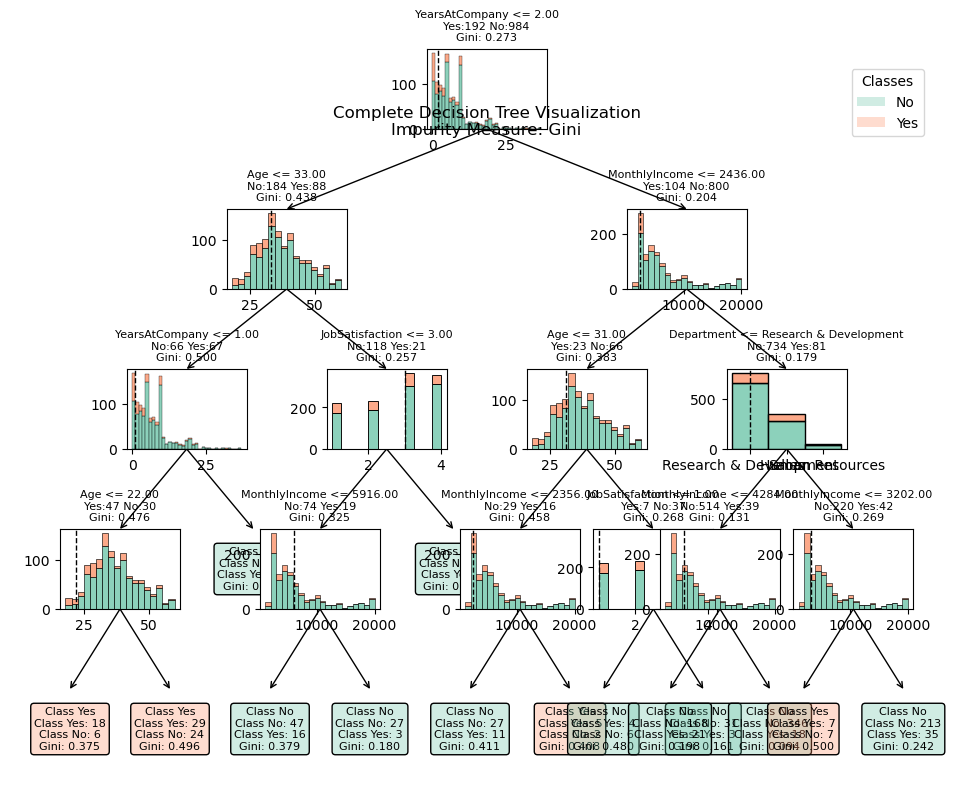

In [38]:
feature_name = ['Department','Gender','Age','EnvironmentSatisfaction','JobSatisfaction','MonthlyIncome','YearsAtCompany']
target_col = 'Attrition'
X = df_clean[feature_name].values
Y = df_clean[target_col].values
model = DecisionTreeClassifier(min_sample_split=5, min_sample_leaf=5, max_depth=3, mode='gini')
data = cross_validation(X, Y, model, k=5)
data_df = pd.DataFrame(data['X_train'], columns=feature_name)
data_df[target_col] = data['y_train'].flatten()
viz = TreeVisualization(model, data_df, target_col, feature_name)
viz.plot_prediction_path()